# Proyecto curso de Bigdata
Lo primero de todo es importar las bibliotecas necesarias generales,en cada celda se puede apreciar para que se necesitaron hay unas que son mucho más adelante pero se dejan los imports acá para mayor claridad, igual podemos ver unos muy claros como pyspark que vamos a necesitar desde un principio. Como la carga de datos son muy pesadas le añadirmos 10 gigas al shell de pyspark


In [1]:
import pyspark
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pytest
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--driver-memory 10g pyspark-shell'
import numpy as np
!pip install ipytest
import ipytest
from functools import reduce  
import pandas as pd
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
ipytest.autoconfig()

Creamos la sesión de Spark que vamos a utilizar para el proyecto, pero le decidí añadir que ignorara los Warnings del TaskManager, porque todos los datos son muy pesados, entonces siempre tiraba warning que se estaba consumiendo una gran cantidad de datos lo hacía que se viera muy saturados los outputs, implementando este cambio eran menos confusos. Además también se incluye el jar más actual de postgres

In [2]:
spark = SparkSession.builder \
    .appName("Proyecto-Big-Data") \
    .config("spark.jars", "postgresql-42.7.6.jar") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
_jvm   = spark.sparkContext._jvm
log4j  = _jvm.org.apache.log4j
logger = log4j.LogManager.getLogger("org.apache.spark.scheduler.TaskSetManager")
logger.setLevel(log4j.Level.ERROR)

ps: unrecognized option: p
BusyBox v1.30.1 (2019-10-26 11:23:07 UTC) multi-call binary.

Usage: ps [-o COL1,COL2=HEADER]

Show list of processes

	-o COL1,COL2=HEADER	Select columns for display
25/08/02 20:48:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
/usr/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


## Propuesta
Fuentes de datos analizadas: 
* Asequibilidad de los alimentos
    https://data.chhs.ca.gov/dataset/food-affordability-2006-2010/resource/916e2a2e-383b-4af5-9f5b-310500961cb5
    Datos o features:
    Ind_id, ind_definition, reportyear, race_eth_code, race_eth_name, geotype, geotypevalue, geoname, country_name, country_flips, region_name, region_code, cost_yr, median_income, affordability_ratio, LL95_affordability_ratio, UL95affordability_ratio, se_food_afford, rse_food_afford, food_food_decile, CA_RR_affordability, ave_fam_size, version. 

* Desempleo del estado de california del  2004-2013
    https://data.chhs.ca.gov/dataset/unemployment-2004-2013/resource/2ecd7fda-2317-4fa1-8a6e-1834cfa39cc0
    Ind_id, ind_definition, reportyear, race_eth_code, race_eth_name, geotype, geotypevalue, geoname, country_name, country_flips, region_name, region_code,, Labor_Force, Unenmployment_rate, II_95ci, ul_95ci, se, rse, place_decile, ca_rr, version 

En este caso ambos de estos datasets son del condado de california por lo que su unión es bastante natural, uno trata sobre la asequibilidad de los alimentos y el otro sobre el desempleo, ambos de estos temas se relacionan. Si hay una mayor tasa de desempleo es posible que la accesibilidad de los alimentos se vea influenciada, ambos ocurren en el mismo lapso del tiempo sin embargo en el caso del segundo dataset lo especifica más a que año, en el segundo solamente se muestra el rango entre el 2006-2010.
La “clave” de unión sería el código de región que comparten en común y hacer el análisis a partir de la zona

La variable  a predecir sería “Alta seguridad Alimentaria” (Alta/Baja)
Si un condado tiene alta inseguridad alimentario si el porcentaje del ingreso gastado en alimento supera un umbral en este caso propondría 30%


## Preparación de los datos
Los dos dataset que elegí son del Departamento de Salud de California, uno sobre el desempleo de la región y el otro sobre la asequibilidad de los alimentos, el proposito es ver como se relacionan entre sí. Pero por el momento vamos a hacer lo más básico que es la lectura y creación de esquemas, estos datos los descargué en un json por lo que hay que utilizar las herramientas que lo permiten.


In [3]:
def leer_json(ruta_archivo):
    with open(ruta_archivo, 'r') as f:
        return json.load(f)

def crear_esquema(campos):
    mapeo_tipos = {
        "int": IntegerType(),
        "text": StringType()
    }
    return StructType([
        StructField(campo['id'], mapeo_tipos.get(campo['type'], StringType()), True)
        for campo in campos
    ])

Una vez cargado los datos generamos un Dataframe con la funcionalidad de Pyspark y otra función que realice casting de tipos de datos en cada columna

In [4]:
def crear_dataframe(spark, registros, esquema):
    rdd = spark.sparkContext.parallelize(registros)
    return spark.createDataFrame(rdd, esquema)

def convertir_tipos(df, campos):
    mapeo_tipos = {
        "int": IntegerType(),
        "text": StringType()
    }
    for campo in campos:
        tipo_spark = mapeo_tipos.get(campo['type'], StringType())
        df = df.withColumn(campo['id'], col(campo['id']).cast(tipo_spark))
    return df



### Limpieza básica
Más avanzado en el proyecto haremos un limpieza más profunda por el momento es una muy sencilla, cambiar los nulos por la palabra "Desconocido" y una función que genere los prints para confirmar que si carguen


In [5]:
def limpiar_dataframe(df): #Limpieza básica nada muy complejo
    df = df.dropDuplicates()
    return df.na.fill("Desconocido")

def validar_carga(df, nombre_dataset): #prints
    print(f"\nValidación de {nombre_dataset}:")
    print(f"- Registros cargados: {df.count()}")
    print(f"- Columnas: {len(df.columns)}")
    df.printSchema()
    return df

### Carga
Por último juntamos en una función todos los distintos procesos que vimos anteriormente, todo con el fin de que esté modularizado, en esta misma celda vamos a correr los procesos, por lo que vamos a observar la estructura de cada dataset, cuantos registros se cargaron y cuantas columnas poseen.

In [6]:

def cargar_dataset(ruta_archivo, spark, nombre_dataset):
    datos_crudos = leer_json(ruta_archivo)
    campos = datos_crudos['fields']
    registros = datos_crudos['records']  
    esquema = crear_esquema(campos)
    df = crear_dataframe(spark, registros, esquema)
    df = convertir_tipos(df, campos)
    df = limpiar_dataframe(df)
    return validar_carga(df, nombre_dataset)

df_comida = cargar_dataset("comida.json", spark, "Datos de Comida")
df_desempleo = cargar_dataset("desempleo.json", spark, "Datos de Desempleo")


Validación de Datos de Comida:


- Registros cargados: 14365
- Columnas: 24
root
 |-- _id: integer (nullable = true)
 |-- ind_id: string (nullable = false)
 |-- ind_definition: string (nullable = false)
 |-- reportyear: string (nullable = false)
 |-- race_eth_code: string (nullable = false)
 |-- race_eth_name: string (nullable = false)
 |-- geotype: string (nullable = false)
 |-- geotypevalue: string (nullable = false)
 |-- geoname: string (nullable = false)
 |-- county_name: string (nullable = false)
 |-- county_fips: string (nullable = false)
 |-- region_name: string (nullable = false)
 |-- region_code: string (nullable = false)
 |-- cost_yr: string (nullable = false)
 |-- median_income: string (nullable = false)
 |-- affordability_ratio: string (nullable = false)
 |-- LL95_affordability_ratio: string (nullable = false)
 |-- UL95_affordability_ratio: string (nullable = false)
 |-- se_food_afford: string (nullable = false)
 |-- rse_food_afford: string (nullable = false)
 |-- food_afford_decile: string (nullable = fal

- Registros cargados: 106411
- Columnas: 23
root
 |-- _id: integer (nullable = true)
 |-- ind_id: string (nullable = false)
 |-- ind_definition: string (nullable = false)
 |-- reportyear: string (nullable = false)
 |-- race_eth_code: string (nullable = false)
 |-- race_eth_name: string (nullable = false)
 |-- geotype: string (nullable = false)
 |-- geotypevalue: string (nullable = false)
 |-- geoname: string (nullable = false)
 |-- county_fips: string (nullable = false)
 |-- county_name: string (nullable = false)
 |-- region_code: string (nullable = false)
 |-- region_name: string (nullable = false)
 |-- Unemployment: string (nullable = false)
 |-- Labor_force: string (nullable = false)
 |-- Unemployment_rate: string (nullable = false)
 |-- ll_95ci: string (nullable = false)
 |-- ul_95ci: string (nullable = false)
 |-- se: string (nullable = false)
 |-- rse: string (nullable = false)
 |-- place_decile: string (nullable = false)
 |-- ca_rr: string (nullable = false)
 |-- version: string

## Pruebas unitarias 
Parte de la verificación necesaria para poder comprobar que todo se importo correctamente es la de hacer pruebas en pytests.
Estas van a ser las pruebas por comprobar:

* Esquema: Va a verificar el nombre de las columnas y los tipos de datos
* Conteo: Que se cargaron todos los registros
* Nulos: Que cambie los valores nulos por "Desconocido"
* Valores: Los no nulos están igual


Tuve muchos incovenientes a la hora de ejecutarlo dentro del visual studio code pero encontré una forma de hacer las pruebas correr dentro del jupyter notebook directamente, la librería que logra esto es ipytest, usando un comando se logra que jupyter trate todo el código como pruebas pytest.
Por eso tenemos más arriba en los entornos el ipytest.config() que configura todo el ambiente, cuando se encuentre con el comando "%%ipytest -v" va a interpretar todo lo que haya más abajo como pytest. Por esto mismo lo hago todo en una celda.

Con el fixtures preparamos las pruebas y generamos los datos de prueba.
Para no tener que probar los miles de datos de california utilizamos 4 datos que van a servir de ejemplo para verificar que la función esta haciendo todo correctamente. Estos datos son del dataset, de los primeros de cada uno, eso significa que si pasan  se están cargando de forma correcta y por ende podemos confiar en el los datos masivos van a servir de la misma manera
Esto no esta verificando la unión ya que esta ocurre más adelante.

Por último el bloque de código es muy extenso pero se tiene que hacer de esta forma ya que si se divide en dos celdas no se van a poder ejecutar las pruebas, esto es como si fuera un nuevo entorno por decirlo de cierta forma por eso también tenemos que volver a abrir la sesión de spark.

In [7]:
%%ipytest -v




@pytest.fixture(scope="module") 

def spark():
    spark = SparkSession.builder \
        .master("local[1]") \
        .appName("Pruebas") \
        .getOrCreate()
    try:
        yield spark
    finally:
        spark.stop()
    # Datos de comida
@pytest.fixture(scope="module")
def df_comida(spark):
    test_comida = {
        "fields": [
            {"id": "_id", "type": "int"},
            {"id": "ind_id", "type": "text"},
            {"id": "ind_definition", "type": "text"},
            {"id": "reportyear", "type": "text"},
            {"id": "race_eth_code", "type": "text"},
            {"id": "race_eth_name", "type": "text"},
            {"id": "geotype", "type": "text"},
            {"id": "geotypevalue", "type": "text"},
            {"id": "geoname", "type": "text"},
            {"id": "county_name", "type": "text"},
            {"id": "county_fips", "type": "text"},
            {"id": "region_name", "type": "text"},
            {"id": "region_code", "type": "text"},
            {"id": "cost_yr", "type": "text"},
            {"id": "median_income", "type": "text"},
            {"id": "affordability_ratio", "type": "text"},
            {"id": "LL95_affordability_ratio", "type": "text"},
            {"id": "UL95_affordability_ratio", "type": "text"},
            {"id": "se_food_afford", "type": "text"},
            {"id": "rse_food_afford", "type": "text"},
            {"id": "food_afford_decile", "type": "text"},
            {"id": "CA_RR_Affordability", "type": "text"},
            {"id": "ave_fam_size", "type": "text"},
            {"id": "version", "type": "text"}
        ],
        "records": [
            [1,"757","Food affordability for female-headed household with children under 18 years",
             "2006-2010","1","AIAN","CA","06","California",None,None,"California",None,
             "7508.2896552","23777","0.3157795","0.2315166","0.4000425","0.0429913",
             "13.6143419",None,"1.1853472","3.34","2013-04-12 04:33:06.235000"],
            [2,"757","Food affordability for female-headed household with children under 18 years",
             "2006-2010","2","Asian","CA","06","California",None,None,"California",None,
             "7508.2896552","38508","0.19498","0.1830649","0.2068951","0.0060791",
             "3.1178142",None,"0.7318999","3.34","2013-04-12 04:33:06.235000"]
        ]
    }
    
    test_path = "test_comida.json"
    with open(test_path, 'w') as f:
        json.dump(test_comida, f)
    
    df = cargar_dataset(test_path, spark, "Datos de Comida de Prueba")
    yield df
    os.remove(test_path)

# Datos de desempleo 
@pytest.fixture(scope="module")
def df_desempleo(spark):
    test_desempleo = {
        "fields": [
            {"id": "_id", "type": "int"},
            {"id": "ind_id", "type": "text"},
            {"id": "ind_definition", "type": "text"},
            {"id": "reportyear", "type": "text"},
            {"id": "race_eth_code", "type": "text"},
            {"id": "race_eth_name", "type": "text"},
            {"id": "geotype", "type": "text"},
            {"id": "geotypevalue", "type": "text"},
            {"id": "geoname", "type": "text"},
            {"id": "county_fips", "type": "text"},
            {"id": "county_name", "type": "text"},
            {"id": "region_code", "type": "text"},
            {"id": "region_name", "type": "text"},
            {"id": "Unemployment", "type": "text"},
            {"id": "Labor_force", "type": "text"},
            {"id": "Unemployment_rate", "type": "text"},
            {"id": "ll_95ci", "type": "text"},
            {"id": "ul_95ci", "type": "text"},
            {"id": "se", "type": "text"},
            {"id": "rse", "type": "text"},
            {"id": "place_decile", "type": "text"},
            {"id": "ca_rr", "type": "text"},
            {"id": "version", "type": "text"}
        ],
        "records": [
            [4,"290","Unemployment rate","2006-2010","1","AIAN","CA","06","California",
             None,None,None,None,"9673","70286","13.8","12.6085106382979","14.9914893617021",
             "0.60790273556231","4.40509228668341",None,"1","2014-05-22 11:47:47"],
            [5,"290","Unemployment rate","2006-2010","3","AfricanAm","CA","06","California",
             None,None,None,None,"142776","1012992","14.1","13.7425531914894","14.4574468085106",
             "0.182370820668693","1.29341007566449",None,"1","2014-05-22 11:47:47"]
        ]
    }
    
    test_path = "test_desempleo.json"
    with open(test_path, 'w') as f:
        json.dump(test_desempleo, f)
    
    df = cargar_dataset(test_path, spark, "Datos de Desempleo de Prueba")
    yield df
    os.remove(test_path)

# Pruebas para el dataset de comida verifica el esquema del dataset de comida
def test_comida_esquema(df_comida):
    assert set(df_comida.columns) == {
        '_id', 'ind_id', 'ind_definition', 'reportyear', 'race_eth_code', 
        'race_eth_name', 'geotype', 'geotypevalue', 'geoname', 'county_name',
        'county_fips', 'region_name', 'region_code', 'cost_yr', 'median_income',
        'affordability_ratio', 'LL95_affordability_ratio', 'UL95_affordability_ratio',
        'se_food_afford', 'rse_food_afford', 'food_afford_decile', 
        'CA_RR_Affordability', 'ave_fam_size', 'version'
    }
    assert isinstance(df_comida.schema["_id"].dataType, IntegerType)
    assert isinstance(df_comida.schema["ind_definition"].dataType, StringType)
    assert isinstance(df_comida.schema["affordability_ratio"].dataType, StringType)

def test_comida_conteo_registros(df_comida): # Comprueba la cantidad de registros cargados
    assert df_comida.count() == 2

def test_comida_tratamiento_nulos(df_comida): # Valida el manejo de valores nulos que se reemplazaron por "Desconocido
    for col_name in ['county_name', 'county_fips', 'region_code', 'food_afford_decile']:
        nulos = df_comida.filter(col(col_name) == "Desconocido").count()
        assert nulos == 2  # Todos los registros tienen nulos


def test_comida_valores_conocidos(df_comida): # Verifica que los valores no nulos se mantienen correctamente
    sample = df_comida.filter(col("_id") == 2).first()
    assert sample.race_eth_name == "Asian"
    assert sample.ave_fam_size == "3.34"
    assert sample.version == "2013-04-12 04:33:06.235000"

# Pruebas para el dataset de desempleo verifica el esquema
def test_desempleo_esquema(df_desempleo):
    assert set(df_desempleo.columns) == {
        '_id', 'ind_id', 'ind_definition', 'reportyear', 'race_eth_code',
        'race_eth_name', 'geotype', 'geotypevalue', 'geoname', 'county_fips',
        'county_name', 'region_code', 'region_name', 'Unemployment', 'Labor_force',
        'Unemployment_rate', 'll_95ci', 'ul_95ci', 'se', 'rse', 'place_decile',
        'ca_rr', 'version'
    }
    assert isinstance(df_desempleo.schema["_id"].dataType, IntegerType)
    assert isinstance(df_desempleo.schema["Unemployment_rate"].dataType, StringType)
    assert isinstance(df_desempleo.schema["version"].dataType, StringType)

def test_desempleo_conteo_registros(df_desempleo): # Comprueba la cantidad de registros cargados
    assert df_desempleo.count() == 2

def test_desempleo_tratamiento_nulos(df_desempleo): #  Valida el manejo de valores nulos que se reemplazaron por "Desconocido
    for col_name in ['county_fips', 'county_name', 'region_code', 'region_name', 'place_decile']:
        nulos = df_desempleo.filter(col(col_name) == "Desconocido").count()
        assert nulos == 2  # Todos los registros tienen nulos e


def test_desempleo_valores_conocidos(df_desempleo):
    sample = df_desempleo.filter(col("_id") == 5).first()
    assert sample.race_eth_name == "AfricanAm"
    assert sample.Unemployment_rate == "14.1"
    assert sample.ca_rr == "1"

======================================= test session starts ========================================
platform linux -- Python 3.7.10, pytest-7.4.4, pluggy-1.2.0
rootdir: /src
plugins: anyio-3.7.1
collected 8 items

t_ecb2a514fc3240db9face65af50fe915.py 

25/08/02 20:48:18 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


........                                               [100%]

======================================== 8 passed in 5.12s =========================================


Con esto comprobamos el esquema, conteo de registros, tratamiento de nulos y valores desconocidos para cada uno de los datasets, sabemos que si hace un buen tratamiento con estos datos también lo hará con los más de 5 mil datos que tiene cada uno. 
Aunque eventualmente tendremos que hacer más transformaciones

## Carga a la base Postgres
Nos conectamos a la base de postgres del contenedor como hemos hecho en incontables trabajos y hacemos dos funciones para el guardado de ambos datasets por separado. Como el anterior punto inicio una nueva sesión en spark hay que volverla a hacer porque si no da error, pero utilizamos el mismo que viene arriba.

In [8]:

spark = SparkSession.builder \
    .appName("Proyecto-Big-Data") \
    .config("spark.jars", "postgresql-42.7.6.jar") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
_jvm   = spark.sparkContext._jvm
log4j  = _jvm.org.apache.log4j
logger = log4j.LogManager.getLogger("org.apache.spark.scheduler.TaskSetManager")
logger.setLevel(log4j.Level.ERROR)

def guardar_comida_postgres(df_comida):
    df_comida.write \
        .format("jdbc") \
        .mode("overwrite") \
        .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
        .option("user", "postgres") \
        .option("password", "pword") \
        .option("dbtable", "datos_comida") \
        .save()
    print("Datos de comida guardados en PostgreSQL")

def guardar_desempleo_postgres(df_desempleo):
    df_desempleo.write \
        .format("jdbc") \
        .mode("overwrite") \
        .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
        .option("user", "postgres") \
        .option("password", "pword") \
        .option("dbtable", "datos_desempleo") \
        .save()
    print(" Datos de desempleo guardados en PostgreSQL")

df_comida = cargar_dataset("comida.json", spark, "Datos de Comida")
df_desempleo = cargar_dataset("desempleo.json", spark, "Datos de Desempleo")
guardar_comida_postgres(df_comida)
guardar_desempleo_postgres(df_desempleo)


/usr/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)



Validación de Datos de Comida:


- Registros cargados: 14365
- Columnas: 24
root
 |-- _id: integer (nullable = true)
 |-- ind_id: string (nullable = false)
 |-- ind_definition: string (nullable = false)
 |-- reportyear: string (nullable = false)
 |-- race_eth_code: string (nullable = false)
 |-- race_eth_name: string (nullable = false)
 |-- geotype: string (nullable = false)
 |-- geotypevalue: string (nullable = false)
 |-- geoname: string (nullable = false)
 |-- county_name: string (nullable = false)
 |-- county_fips: string (nullable = false)
 |-- region_name: string (nullable = false)
 |-- region_code: string (nullable = false)
 |-- cost_yr: string (nullable = false)
 |-- median_income: string (nullable = false)
 |-- affordability_ratio: string (nullable = false)
 |-- LL95_affordability_ratio: string (nullable = false)
 |-- UL95_affordability_ratio: string (nullable = false)
 |-- se_food_afford: string (nullable = false)
 |-- rse_food_afford: string (nullable = false)
 |-- food_afford_decile: string (nullable = fal

 Datos de desempleo guardados en PostgreSQL


Para comprobar que si están en la base y no sean solo los prints realizamos funciones de lecturas y una impresión sobre ellas. 

In [9]:

def leer_comida_postgres():
    print("Lectura de comida.json")
    return spark.read \
        .format("jdbc") \
        .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
        .option("user", "postgres") \
        .option("password", "pword") \
        .option("dbtable", "datos_comida") \
        .load()

def leer_desempleo_postgres():
    print("Lectura de postgres.json")
    return spark.read \
        .format("jdbc") \
        .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
        .option("user", "postgres") \
        .option("password", "pword") \
        .option("dbtable", "datos_desempleo") \
        .load()

comida_db = leer_comida_postgres()
comida_db.show(2, vertical=True, truncate=False)

desempleo_db = leer_desempleo_postgres()
desempleo_db.show(2, vertical=True, truncate=False)

#Verificación final
print(f"- Comida: {comida_db.count()} registros cargados")
print(f"- Desempleo: {desempleo_db.count()} registros cargados")

Lectura de comida.json
-RECORD 0-----------------------------------------------------------------------------------------------
 _id                      | 499                                                                         
 ind_id                   | 757                                                                         
 ind_definition           | Food affordability for female-headed household with children under 18 years 
 reportyear               | 2006-2010                                                                   
 race_eth_code            | 4                                                                           
 race_eth_name            | Latino                                                                      
 geotype                  | CO                                                                          
 geotypevalue             | 06109                                                                       
 geoname                  | Tuol

-RECORD 0---------------------------------
 _id               | 59                   
 ind_id            | 290                  
 ind_definition    | Unemployment rate    
 reportyear        | 2006-2010            
 race_eth_code     | 4                    
 race_eth_name     | Latino               
 geotype           | CD                   
 geotypevalue      | 0600191660           
 geoname           | Livermore-Pleasanton 
 county_fips       | 06001                
 county_name       | Alameda              
 region_code       | 01                   
 region_name       | Bay Area             
 Unemployment      | 1263                 
 Labor_force       | 14940                
 Unemployment_rate | 8.5                  
 ll_95ci           | 6.47446808510638     
 ul_95ci           | 10.5255319148936     
 se                | 1.03343465045593     
 rse               | 12.1580547112462     
 place_decile      | Desconocido          
 ca_rr             | 0.80188679245283     
 version   

## Unión de datasets y guardado en la base
Hay un aspecto con los datasets que me gustaría manipular antes de la únion y es que en uno de ellos todos los datos son del 2006 al 2010 y es representado "2006-2010" sin embargo en el otro tiene una representación mixta, a veces tiene el año específico y otras veces el rango de valores, por lo que me gustaría unificar ese dato.


Además el dataset del desempleo cuenta con 106 mil datos que son mucho más que los 14 mil de la asequibilidad de los alimentos, sin embargo hay muchos que tienen practicamente todas sus columnas vacías por lo que antes de la fusión en los datasets me gustaría limpiar aquellos que tengan 5 nulos o más para disminuir un poco la cantidad y no haya tantas columnas que no aportan ningún dato relevante.
Para la última hay una línea que me gustaría explicar más a detalle, sería     expr = reduce(lambda a, b: a + b, (F.when(F.col(c).isNull(), 1).otherwise(0) for c in df.columns)).

Contamos con el reduce() que es una función que aplica una suma a la función lambda a,b: a+b, lo que significa que se está sumando cada uno de los elementos, esta parte es sencilla, pero después viene un generador que itera por fila y si el valor es nulo le pone un 1 si no un 0. Todo junto lo que hace es sumar cuantos nulos hay y ya después borra las que tengan más de 5 nulos



In [10]:



def homogenizar_anos_desempleo(df):
    return df.withColumn(
        "reportyear",
        F.when(
            F.col("reportyear").isin(["2006", "2007", "2008", "2009", "2010"]),
            "2006-2010"
        ).otherwise(F.col("reportyear"))
    )


def imprimir_y_eliminar_filas_con_desconocido(df: DataFrame, max_desconocido: int = 7):
    expr = reduce(lambda a, b: a + b, (F.when(F.col(c) == "Desconocido", 1).otherwise(0) for c in df.columns))
    filas_eliminadas = df.filter(expr >= max_desconocido)
    numero_filas_eliminadas = filas_eliminadas.count()
    print(f"Número de filas eliminadas): {numero_filas_eliminadas}")
    df_filtrado = df.filter(expr < max_desconocido)
    return df_filtrado


#### Preparación
Ya con esto traemos los datos de la base y realizamos la limpieza más compleja antes de la unión

In [11]:

df_comida = leer_comida_postgres()
df_desempleo = leer_desempleo_postgres()


df_comida = imprimir_y_eliminar_filas_con_desconocido(df_comida) 
df_desempleo = homogenizar_anos_desempleo(df_desempleo)
df_desempleo = imprimir_y_eliminar_filas_con_desconocido(df_desempleo)

Lectura de comida.json
Lectura de postgres.json
Número de filas eliminadas): 10995


Número de filas eliminadas): 76025


#### Union
Como ambos datasets son muy similares habían nombres de columnas exactamente iguales, esto generaba bastante conflictos a la hora de cruzarlos por lo que renombramos la gran mayoría para que no hayan confusiones.

In [12]:

df_desempleo = df_desempleo.withColumnRenamed("ind_id", "ind_id_desempleo") \
                           .withColumnRenamed("ind_definition", "ind_definition_desempleo") \
                           .withColumnRenamed("reportyear", "reportyear_desempleo") \
                           .withColumnRenamed("race_eth_code", "race_eth_code_desempleo") \
                           .withColumnRenamed("race_eth_name", "race_eth_name_desempleo") \
                           .withColumnRenamed("geotype", "geotype_desempleo") \
                           .withColumnRenamed("geoname", "geoname_desempleo") \
                           .withColumnRenamed("county_name", "county_name_desempleo") \
                           .withColumnRenamed("county_fips", "county_fips_desempleo") \
                           .withColumnRenamed("region_name", "region_name_desempleo") \
                           .withColumnRenamed("region_code", "region_code_desempleo") \
                           .withColumnRenamed("version", "version_desempleo") \
                           .withColumnRenamed("_id", "region_id")



Ya una vez cambiadas cuando hacemos la unión hay que tomar en cuenta tomar que no se eliminen columnas, pero además que haya un único valor geotypevalue y no se duplique.

In [13]:
# Realizar el join usando 'geotypevalue'
combined_df = df_comida.join(
    df_desempleo,
    df_comida['geotypevalue'] == df_desempleo['geotypevalue'],
    'inner'
)
combined_df = combined_df.select(
    df_comida['geotypevalue'],  
    "ind_id", "ind_definition", "reportyear", 
    "race_eth_code", "race_eth_name", "geotype",
    "geoname", "county_name", "county_fips",
    "region_name", "region_code", "cost_yr",
    "median_income", "affordability_ratio", 
    "LL95_affordability_ratio", "UL95_affordability_ratio",
    "se_food_afford", "rse_food_afford",
    "food_afford_decile", "CA_RR_Affordability",
    "ave_fam_size", "version",
    "region_id", "ind_id_desempleo", "ind_definition_desempleo",
    "reportyear_desempleo", "race_eth_code_desempleo", 
    "race_eth_name_desempleo", "geotype_desempleo",
    "geoname_desempleo", "county_fips_desempleo", 
    "county_name_desempleo", "region_code_desempleo",
    "region_name_desempleo", "Unemployment", 
    "Labor_force", "Unemployment_rate", 
    "ll_95ci", "ul_95ci", "se", "rse", 
    "place_decile", "ca_rr", "version_desempleo"
)
combined_df.show(5)

combined_df.show(5, truncate=False)


# Contar el número de filas en el DataFrame combinado
numero_filas = combined_df.count()
print(f"El número total de filas es: {numero_filas}")


25/08/02 20:48:36 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------+------+--------------------+----------+-------------+-------------+-------+-----------+-----------+-----------+-------------------+-----------+------------+-------------+-------------------+------------------------+------------------------+--------------+---------------+------------------+-------------------+------------+--------------------+---------+----------------+------------------------+--------------------+-----------------------+-----------------------+-----------------+-----------------+---------------------+---------------------+---------------------+---------------------+------------+-----------+-----------------+----------------+----------------+----------------+----------------+------------+----------------+-------------------+
|geotypevalue|ind_id|      ind_definition|reportyear|race_eth_code|race_eth_name|geotype|    geoname|county_name|county_fips|        region_name|region_code|     cost_yr|median_income|affordability_ratio|LL95_affordability_ratio|UL95_a

+------------+------+---------------------------------------------------------------------------+----------+-------------+-------------+-------+-----------+-----------+-----------+-------------------+-----------+------------+-------------+-------------------+------------------------+------------------------+--------------+---------------+------------------+-------------------+------------+--------------------------+---------+----------------+------------------------+--------------------+-----------------------+-----------------------+-----------------+-----------------+---------------------+---------------------+---------------------+---------------------+------------+-----------+-----------------+----------------+----------------+----------------+----------------+------------+----------------+-------------------+
|geotypevalue|ind_id|ind_definition                                                             |reportyear|race_eth_code|race_eth_name|geotype|geoname    |county_name|county

El número total de filas es: 32847


### Prueba unitaria de la unión:
Por conflictos que hubieron con el programa esta prueba se encuentra al final del cuaderno de jupyter, para comprobar que fucione se vuelve a ejecutar un procedimiento muy similar al anterior pero con unos datos más sencillos.


#### Variable a predecir
Sin embargo aún tenemos que transformar la columna affordability_ratio, esta va a ser la variable a predecir, pero para hacer esta tarea más sencilla vamos a hacerla una variable binaria. Esta variable se puede entender como "inseguridad_alimentaria" se basa que cuando el porcentaje del ingreso gastado en alimentos supera un 30% esta columna tomará los valores "Alta" o "baja" para reflejar si el condado esta en situación de alta seguridad alimentaria o no.

Una cosa extra de esta celda es que tenemos el porcentaje de como está la distribución, esto es relevante porque si hubiera un desbalance muy grande puede llevar a que la predicción sea muy erronéa 

In [14]:
spark = SparkSession.builder \
    .appName("Proyecto-Big-Data") \
    .config("spark.jars", "postgresql-42.7.6.jar") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
_jvm   = spark.sparkContext._jvm
log4j  = _jvm.org.apache.log4j
logger = log4j.LogManager.getLogger("org.apache.spark.scheduler.TaskSetManager")
logger.setLevel(log4j.Level.ERROR)


def identificar_nivel_inseguridad_alimentaria(df: DataFrame, umbral: float = 0.3):
    return df.withColumn(
        "inseguridad_alimentaria",
        F.when(F.col("affordability_ratio").cast("float") > umbral, "Alta").otherwise("Baja")
    )

combined_df_con_nivel_inseguridad = identificar_nivel_inseguridad_alimentaria(combined_df)

combined_df_con_nivel_inseguridad.show(5, truncate=False)

distribucion = combined_df_con_nivel_inseguridad.groupBy("inseguridad_alimentaria").count()

distribucion.show()

total = combined_df_con_nivel_inseguridad.count()
distribucion_con_porcentaje = distribucion.withColumn(
    "porcentaje", 
    F.round((F.col("count") / total) * 100, 2))
distribucion_con_porcentaje.show()

+------------+------+---------------------------------------------------------------------------+----------+-------------+-------------+-------+-----------+-----------+-----------+-------------------+-----------+------------+-------------+-------------------+------------------------+------------------------+--------------+---------------+------------------+-------------------+------------+--------------------------+---------+----------------+------------------------+--------------------+-----------------------+-----------------------+-----------------+-----------------+---------------------+---------------------+---------------------+---------------------+------------+-----------+-----------------+----------------+----------------+----------------+----------------+------------+----------------+-------------------+-----------------------+
|geotypevalue|ind_id|ind_definition                                                             |reportyear|race_eth_code|race_eth_name|geotype|geonam

+-----------------------+-----+
|inseguridad_alimentaria|count|
+-----------------------+-----+
|                   Alta|10836|
|                   Baja|22011|
+-----------------------+-----+



+-----------------------+-----+----------+
|inseguridad_alimentaria|count|porcentaje|
+-----------------------+-----+----------+
|                   Alta|10836|     32.99|
|                   Baja|22011|     67.01|
+-----------------------+-----+----------+



La distribución es muy buena, no cae en un desbalance muy grande pero tampoco en 50/50, por lo que sabemos es un buena variable a predecir
Finalmente la guardamos en la base de datos 

In [15]:
def guardar_combined_df_postgres(df):
    df.write \
        .format("jdbc") \
        .mode("overwrite") \
        .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
        .option("user", "postgres") \
        .option("password", "pword") \
        .option("dbtable", "datos_combinados") \
        .save()
 
# Guardar el DataFrame combinado
guardar_combined_df_postgres(combined_df_con_nivel_inseguridad)
print("Datos combinados guardados en PostgreSQL")

Datos combinados guardados en PostgreSQL


Igualmente comprobamos que si se haya guardado bien con la lectura y esta función nos va a servir más adelante

In [16]:

def leer_combined_postgres():
    print("Lectura de la tabla de datos combinados en PostgreSQL")
    return spark.read \
        .format("jdbc") \
        .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
        .option("user", "postgres") \
        .option("password", "pword") \
        .option("dbtable", "datos_combinados") \
        .load()

# Leer el DataFrame combinado desde PostgreSQL
df_combined_verificado = leer_combined_postgres()

# Mostrar algunas filas para verificar que se guardó correctamente
df_combined_verificado.show(5, truncate=False)


Lectura de la tabla de datos combinados en PostgreSQL


+------------+------+---------------------------------------------------------------------------+----------+-------------+-------------+-------+------------+-----------+-----------+---------------+-----------+-----------+-------------+-------------------+------------------------+------------------------+--------------+---------------+------------------+-------------------+------------+--------------------------+---------+----------------+------------------------+--------------------+-----------------------+-----------------------+-----------------+-----------------+---------------------+---------------------+---------------------+---------------------+------------+-----------+-----------------+-------+----------------+----------------+----------------+------------+----------------+-------------------+-----------------------+
|geotypevalue|ind_id|ind_definition                                                             |reportyear|race_eth_code|race_eth_name|geotype|geoname     |county

## Boxplots y otros gráficos

Podemos sacar varias conclusiones de los boxplots, y en realidad la mayoria cae en cierta categoría, por lo que no veo necesario explicar cada uno de ellos, estos 3 ejemplos son más que suficientes para entenderlo correctamente:


* Feature cost year: Es de los más balanceados que hay, teniendo la mediana cerca de los 8000, el rango intercuartilico la mayoría de datos se encuentre entre 7000 y 85000, pero también hay bastantes valores atipicos. 

* ul95_affordability_ratio: Vemos que la mediana esta cerca de 0, osea que la mayoría de valores están concentrado en valores bajos, y la caja es muy pequeña por lo que la mayoría de datos estan muy cercanos entre si. Pero también hay muchos valores atipicos super altos.

* rse: La mediana esta alrededor de 40, teniendo los datos entre 30 y 60 y existen valores muchos valores atipicos igualmemte. 
El resto de los features siguen uno de estos patrones similares.


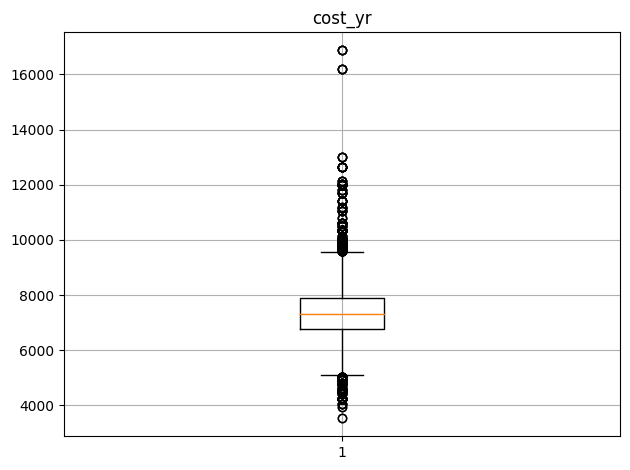

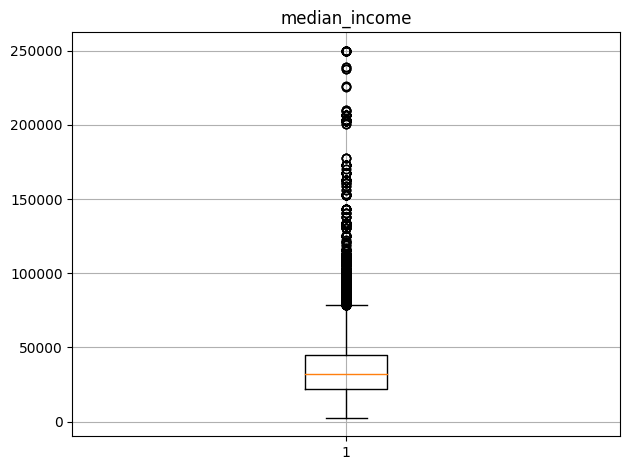

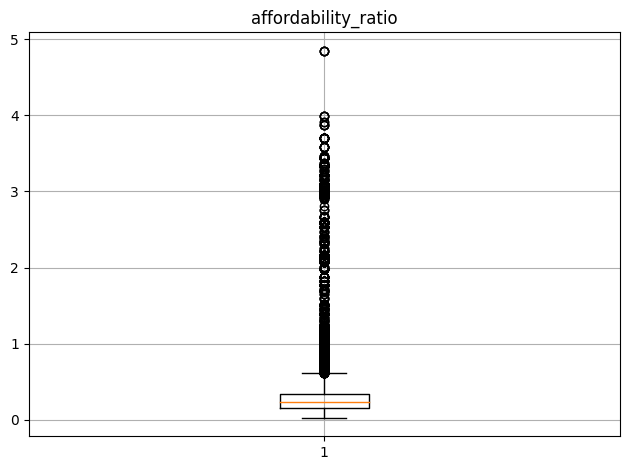

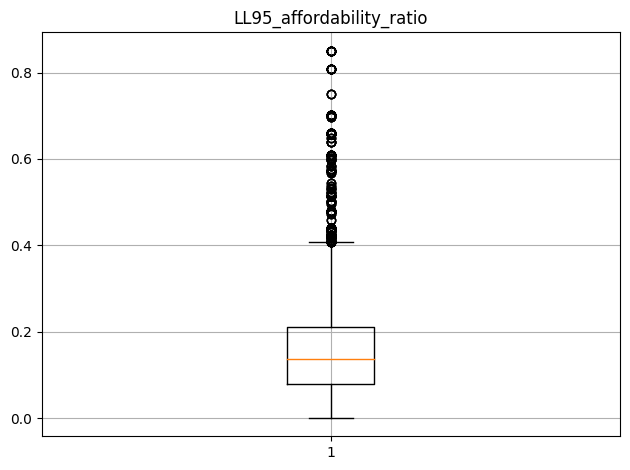

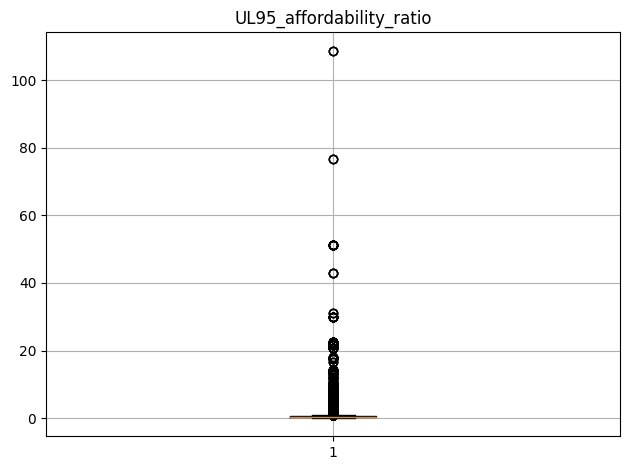

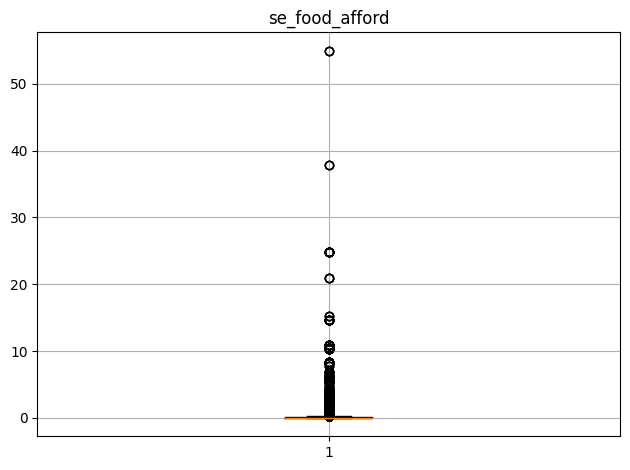

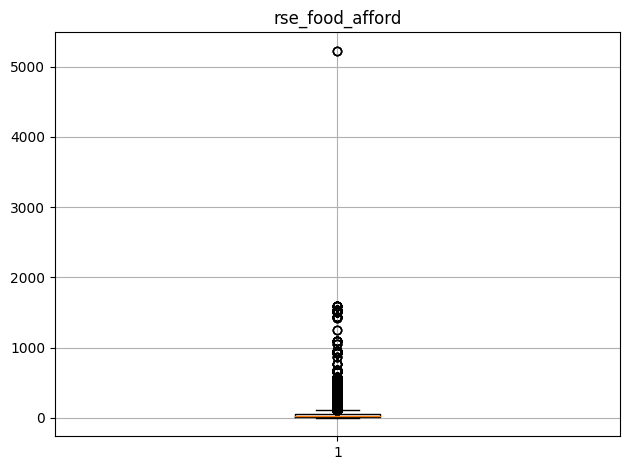

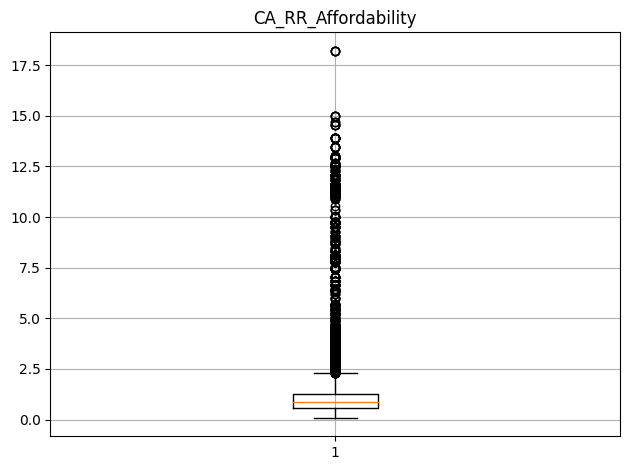

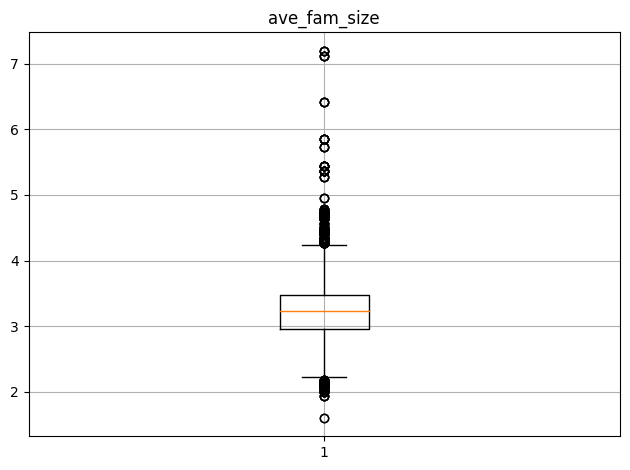

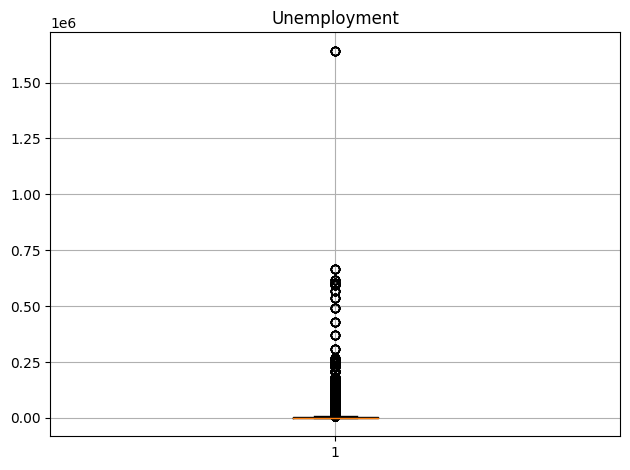

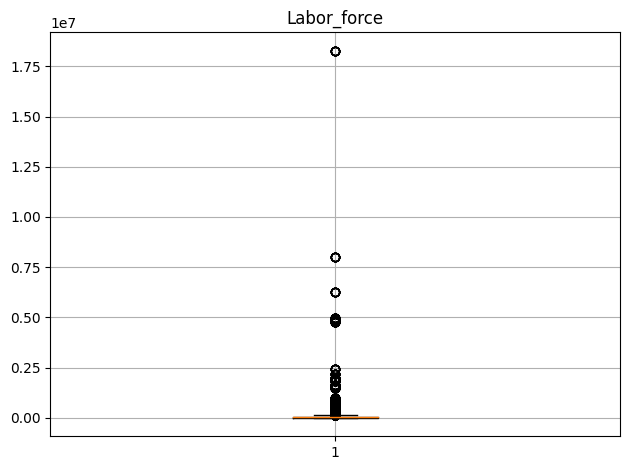

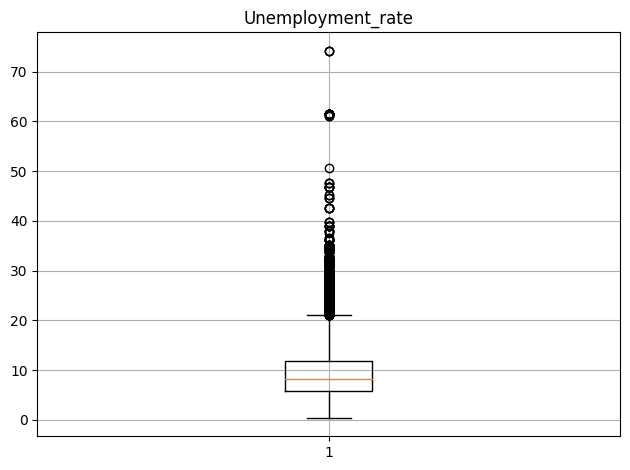

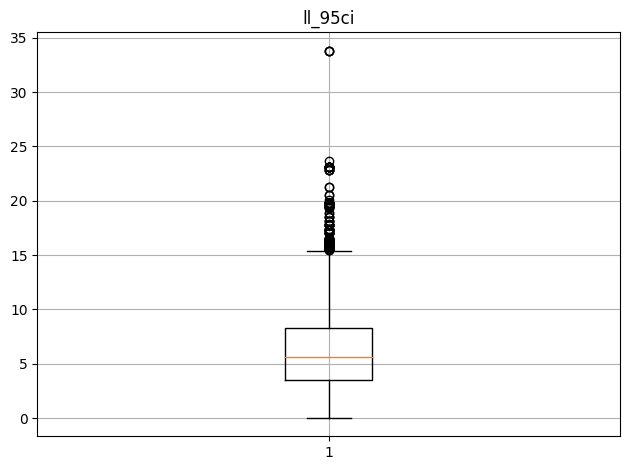

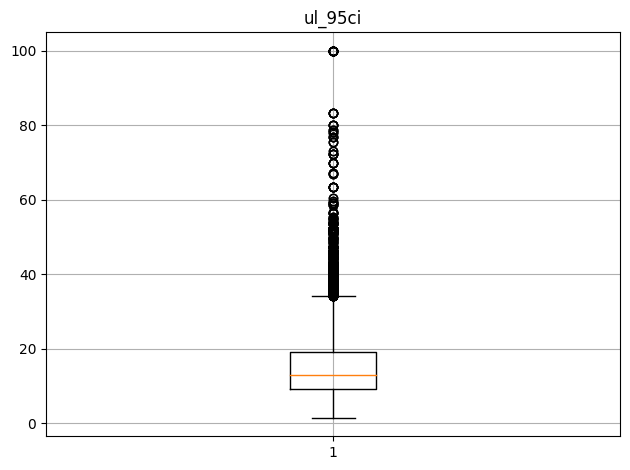

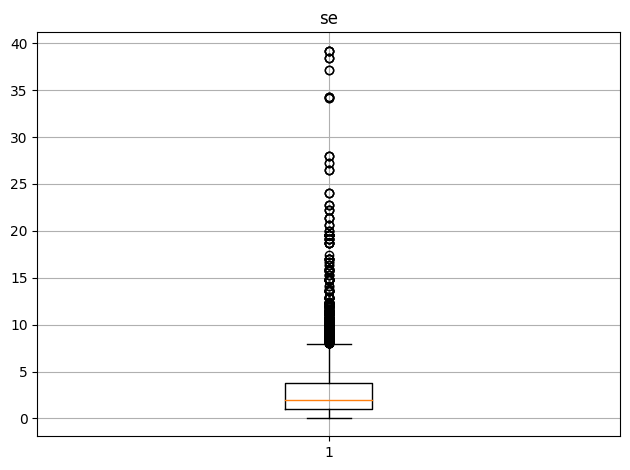

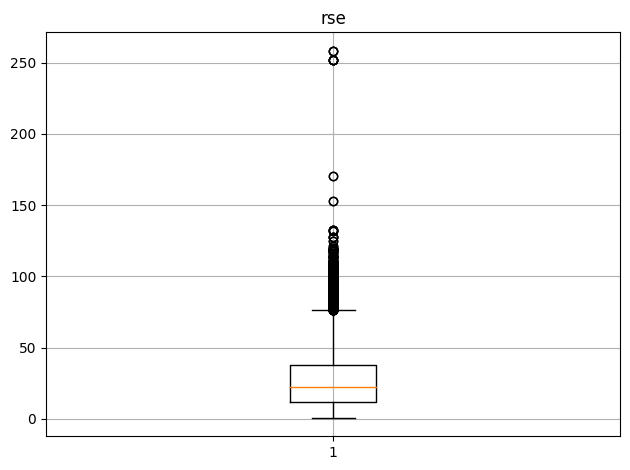

In [17]:

def convertir_columnas_a_float(df, columns):
    for col_name in columns:
        df = df.withColumn(col_name, df[col_name].cast(FloatType()))
    return df

cols = [
    "cost_yr", "median_income", "affordability_ratio", "LL95_affordability_ratio",
    "UL95_affordability_ratio", "se_food_afford", "rse_food_afford",
    "CA_RR_Affordability", "ave_fam_size", "Unemployment", "Labor_force",
    "Unemployment_rate", "ll_95ci", "ul_95ci", "se", "rse"
]
combined_df = convertir_columnas_a_float(combined_df, cols)


# Recopilar datos de las columnas seleccionadas
datos = {col: [] for col in cols}

for fila in combined_df.select(cols).collect():
    for col in cols:
        if fila[col] :
            datos[col].append(float(fila[col]))
            

# Generar y mostrar boxplots
for feature_name, feature_data in datos.items():
    plt.figure()
    plt.boxplot(feature_data)
    plt.title(feature_name)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Se ve que hay variables en las que los _outliers_ pueden aportar contexto al no estar muy lejos de los IQRs, pero otras en las que definitivamente hay valores muy extremos.

Sobre los rangos intercualtilicos podemos ver muchos valores negativos lo que significa que no hay outliers por debajo de cero. 
Pero también en la mayoría de variables hay un rango superior amplio lo que podría llevar a sesgo en el analisis.

In [18]:

# Calcular los límites IQR para cada columna
iqr_bounds = {}
for col in cols:
    q1, q3 = combined_df.approxQuantile(col, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    iqr_bounds[col] = (lower_bound, upper_bound)

for col, bounds in iqr_bounds.items():
    print(f"Límites IQR para {col}: Inferior = {bounds[0]}, Superior = {bounds[1]}")

Límites IQR para cost_yr: Inferior = 5069.904541015625, Superior = 9563.941650390625
Límites IQR para median_income: Inferior = -10960.0, Superior = 76784.0
Límites IQR para affordability_ratio: Inferior = -0.10571698844432831, Superior = 0.5979805737733841
Límites IQR para LL95_affordability_ratio: Inferior = -0.26535914093255997, Superior = 0.44226523488759995
Límites IQR para UL95_affordability_ratio: Inferior = -0.21607037633657455, Superior = 0.9676124826073647
Límites IQR para se_food_afford: Inferior = -0.10543510038405657, Superior = 0.23831609915941954
Límites IQR para rse_food_afford: Inferior = -44.031625747680664, Superior = 103.56064414978027
Límites IQR para CA_RR_Affordability: Inferior = -0.39683154225349426, Superior = 2.2446500957012177
Límites IQR para ave_fam_size: Inferior = 2.1950000524520874, Superior = 4.235000014305115
Límites IQR para Unemployment: Inferior = -5053.0, Superior = 9387.0
Límites IQR para Labor_force: Inferior = -64202.5, Superior = 117969.5
Lími

Aquí podemos observar que realmente los datos tienen una distribución muy marcada con valores fuera de los límites superior e inferiores por lo que hay muchas situaciones atipicas. Esto será un factor importante por marcar en la comparación de modelos


25/08/02 20:49:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


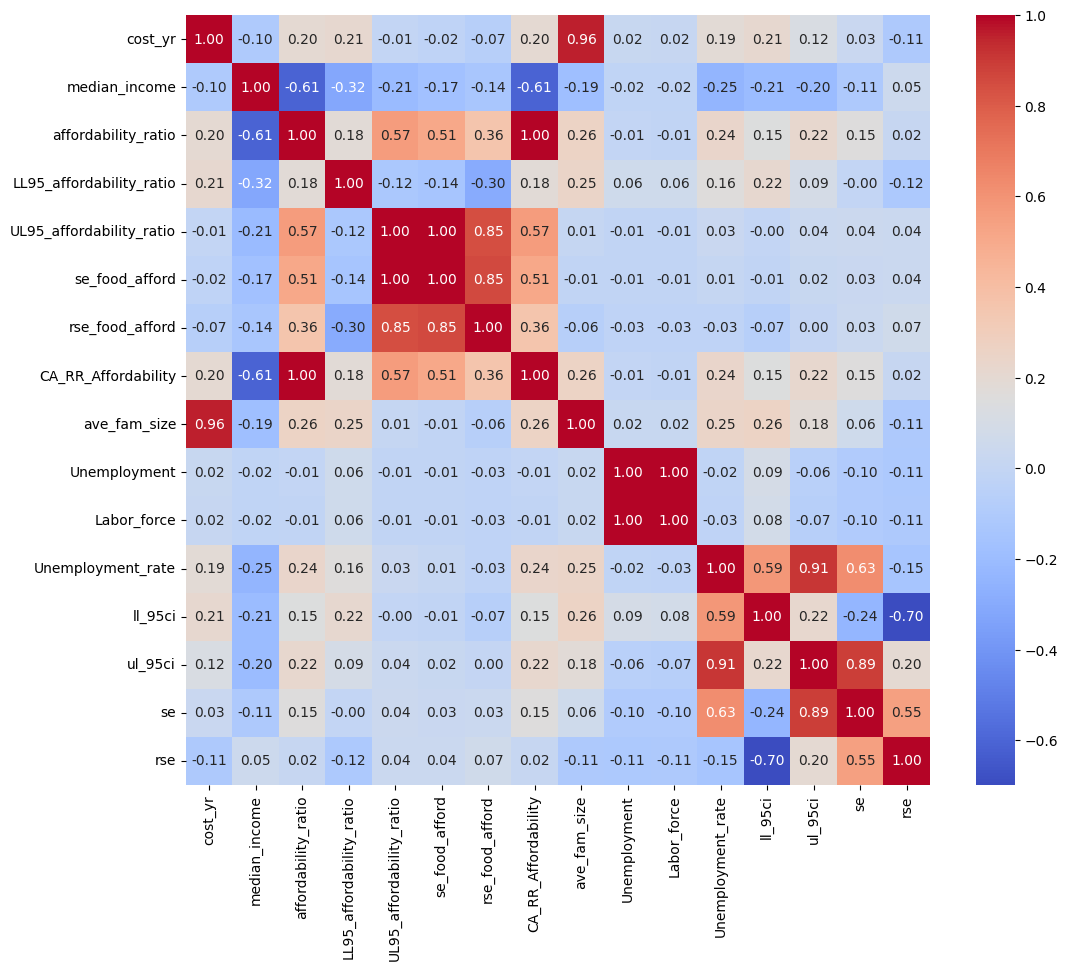

In [19]:

clean_df = combined_df.na.drop(subset=cols)

clean_df = convertir_columnas_a_float(clean_df, cols)

assembler = VectorAssembler(inputCols=cols, outputCol="features")
vector_df = assembler.transform(clean_df).select("features")

# Cálculo de la matriz de correlación de Pearson
pearson_matrix = Correlation.corr(vector_df, 'features').head()[0]

corr_matrix_array = pearson_matrix.toArray()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_array, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=cols, yticklabels=cols)
plt.show()

De esta matriz podemos sacar varias conclusiones pero voy a resaltar las más destacables.
Tenemos 4 princiaples correlaciones fuertes positivas:
* cost_yr con ave_fam_size existe una gran correlación positiva, con estos podemos concluir que a medida que aumenta el tamaño promedio de la familia, también lo hace el costo anualm, lo cual es bastante lógico.

* Unemployment con Labor_force: Fuertemente correlacionadas, ya que el desempleo está directamente relacionado con la fuerza laboral total.

* Hay una correlación muy fuerte entre affordability_ratio, y los límites LL95 y UL95 como sus errores estandar, lo que indica redundancia informativa, aspecto muy importante ya que esta va a ser nuestra variable a predecir.


Relaciones menos notables pero igualmente importante:
* median_income y affordability_ratio: No estan fuerte como las otras pero sugiere que un mayor ingreso mediano reduce el ratio de asequibilidad. 

El resto de correlaciones están cerca de 0 por lo que no vale mucho la pena destacar nada 

## Propuestas 

Los dos modelos que se van a entrenar van a tratar de predecir la variable "inseguridad alimentaria" que puede tomar el valor alta o baja, esta es una variable que se relaciona con affordability_ratio.
Pero esto trae consigo varios aspectos importantes sobre que features vamos a utilizar para entrenar el modelo. Incluir cualquier derivado de esta variable (LL95, UL95, se, rse) va a llevar a una predicción muy trivial, de hecho esto es algo que intenté y llevo a un overfitting.

La clave para que esto no ocurra es utilizar predictores exógenos con un sesgo más bajo, por lo que para ambas propuestas voy a utilizar ave_fam_size, Unemployment_rate, Labor_force, cost_yr.
Tiene sentido ya que una familia muy grade puede ser más complicado asegurar la asequibilidad del alimento, así como estados con una tasa de desempleo muy alta y el costo por año, pero todas estos factores no son completamente decisivos, lo que lleva a que se ajuste más correctamente con la variable a predecir sin caer en un Overfitting. Otra variable que causaba este mismo problema era "median income" en la matriz de correlación vemos que tienen una relación opuesta pero cuando se trataba de añadir al modelo este tenía un sesgo iguamente.



### Preprocesado desde la base de datos
Un aspecto que no tome en cuenta a la hora de entrenar los modelos es que en realidad en la base de datos se están guardando variables como String, para poder manipularlas necesitan ser un float, también borra las filas si tienen nulo porque no van a servir para la predicción, por ese motivo existe esta función que utilizan ambos modelos.  


In [20]:

def limpieza_datos(df, feature_columns):
   
    for col_name in feature_columns:
        df = df.withColumn(
            col_name,
            F.when(F.col(col_name) == "Desconocido", None)
            .otherwise(F.col(col_name).cast("float")))
    
    df_clean = df.na.drop(subset=feature_columns)
    
    return df_clean

## Primer modelo (Random Forest)


Un aspecto implemente para evitar el overfitting especificamente en el random forest se impone un límite en la profundidad máxima que podía tener, cambiandolo 5 niveles, cada hoja también tiene que tener un mínimo de 20 hojas asegurando que cada predicción sea un grupo estadísticamente significativo, Max_features lo cambiamos para que cada división del arbol solo "vea" un subconjunto aleatorio de variables, disminuyendo la correlación entre árboles evitar el overfitting.
Fuera de eso se sigue el mismo tratamiento de siempre, definición de características, indexación de variable, ensamblaje de características, división de datos y configuración de Random Forest.


In [21]:

columnas_features_rf = ["ave_fam_size", "Unemployment_rate", "Labor_force", "cost_yr"]

df_clean = limpieza_datos(df_combined_verificado, columnas_features_rf)

indexer = StringIndexer(inputCol="inseguridad_alimentaria", outputCol="label")
df_indexed = indexer.fit(df_clean).transform(df_clean)

assembler = VectorAssembler(
    inputCols=columnas_features_rf, 
    outputCol="features",
    handleInvalid="skip"
)

rf_assembled = assembler.transform(df_indexed)


(entrenamiento_val, validacion_datos) = rf_assembled.randomSplit([0.8, 0.2], seed=42)

# Configurar Random Forest con restricciones de complejidad
randomforest = RandomForestClassifier(
    featuresCol='features',
    labelCol='label',
    numTrees=100,
    maxDepth=5, 
    minInstancesPerNode=20, 
    featureSubsetStrategy='sqrt',
    seed=42
)

#Configurar cuadrícula de parámetros con restricciones
paramGrid = ParamGridBuilder() \
    .addGrid(randomforest.maxDepth, [4, 5, 6]) \
    .addGrid(randomforest.featureSubsetStrategy, ['sqrt', 'log2']) \
    .build()

Aqui ejecutamos la validación cruzada, son 5 folds para que sea eficiente pero igualmente tenga robustez, además calculamos algunas métricas para imprimirlas después.


In [22]:
# Configurar validación cruzada
crossval = CrossValidator(
    estimator=randomforest,
    estimatorParamMaps=paramGrid,
    evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"),
    numFolds=3, 
    seed=42
)

# Entrenamiento
cv_model = crossval.fit(entrenamiento_val)
best_randomforest = cv_model.bestModel

# Predicción
predicciones = best_randomforest.transform(validacion_datos)

#Métricas
roc = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
pr = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderPR")
roc_auc = roc.evaluate(predicciones)
pr_auc = pr.evaluate(predicciones)



### Análisis de resultados 

In [23]:
# Calculo de métricas de clasificación
tp = predicciones.filter((F.col("label") == 1) & (F.col("prediction") == 1)).count()
tn = predicciones.filter((F.col("label") == 0) & (F.col("prediction") == 0)).count()
fp = predicciones.filter((F.col("label") == 0) & (F.col("prediction") == 1)).count()
fn = predicciones.filter((F.col("label") == 1) & (F.col("prediction") == 0)).count()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

#Prints necesarios para el análisis de resultados 
print("\n" + "="*50)
print("Mejores parámetros del modelo:")
print(f"maxDepth: {best_randomforest.getMaxDepth()}")
print(f"minInstancesPerNode: {best_randomforest.getMinInstancesPerNode()}")

print("\nMétricas del modelo:")
print("="*50)
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

importancias = best_randomforest.featureImportances
print("\nImportancia de características:")
for i, col in enumerate(columnas_features_rf):
    print(f"{col}: {importancias[i]:.4f}")

print("\nEjemplos de predicciones:")
predicciones.select("geoname", "region_name", "median_income", "prediction", "label").show(5, truncate=False)


Mejores parámetros del modelo:
maxDepth: 6
minInstancesPerNode: 20

Métricas del modelo:
ROC AUC: 0.7637
PR AUC: 0.6227
Accuracy: 0.7380
Precision: 0.6722
Recall: 0.4237
F1-Score: 0.5198

Importancia de características:
ave_fam_size: 0.4648
Unemployment_rate: 0.3232
Labor_force: 0.0500
cost_yr: 0.1620

Ejemplos de predicciones:


+-------------+-------------------+-------------+----------+-----+
|geoname      |region_name        |median_income|prediction|label|
+-------------+-------------------+-------------+----------+-----+
|Acton CDP    |Southern California|12500        |0.0       |1.0  |
|Acton CDP    |Southern California|12500        |0.0       |1.0  |
|Adelanto city|Southern California|17310        |1.0       |1.0  |
|Adelanto city|Southern California|17310        |1.0       |1.0  |
|Adelanto city|Southern California|17310        |1.0       |1.0  |
+-------------+-------------------+-------------+----------+-----+
only showing top 5 rows



Sobre el aspecto de mejores parámetros ya mencionamos anteriormente porque tienen esos valores.
La interpretación de métricas es lo interesante:


* ROC AUC: El valor 0.7637 indica que tiene una buena capacidad para distinguir ambas clases pero sin caer en un overfitting perfecto, en resumen tiene una discriminación sólida pero muchos casos de inseguridad no se detectan. 
* PR AUC: El valor 0.6227 significa que el rendimiento igual es aceptable
* Accuracy: 0.7380 también es un buen valor aunque nada muy significativo
* Precision: De cada 100 predicciones 67 son correctas.
* Recall: Caprtura el 42% de los casos positivos
* F1-Score: Tiene un equilibrio moderado entre precision y recall


Importancia de características: 
Aquí se ve que la feature que más predonima es el tamaño de la familia, ya que familia más grande se correlacionan con inseguridad alimentaria.
Unenmployment rate: Aporta también bastante, tiene sentido que el desempleo se relaciona con la asequibilidad de los alimentos.
Las otras dos características aunque son tomada en cuenta casi no aportan mucho.


## Regresión Logística


En esta ocasión con Regresión Logísitca seguimos el mismo formato que en el random forest, definimos caracterísica, limpiamos los datos con la función que habíamos hecho anteriormente, indexar la variable objetivo, ensamblamos las característicasm y configuramos la regresión logísitca que usamos los valores por defectos sin hacer nada especial para evitar el overfitting.


In [28]:
feature_columns_logit = ["ave_fam_size", "Unemployment_rate", "Labor_force", "cost_yr"]

 
# Filtrar filas con valores nulos en las características
df_clean_logit = limpieza_datos(df_combined_verificado, feature_columns_logit)

indexer = StringIndexer(inputCol="inseguridad_alimentaria", outputCol="label")
df_indexed_logit = indexer.fit(df_clean_logit).transform(df_clean_logit)

assembler_logit = VectorAssembler(
    inputCols=feature_columns_logit, 
    outputCol="features",
    handleInvalid="skip"
)
df_assembled_logit = assembler_logit.transform(df_indexed_logit)

(entrenamiento_val_logit, validacion_logit) = df_assembled_logit.randomSplit([0.8, 0.2], seed=42)

logisticregression = LogisticRegression(
    featuresCol='features',
    labelCol='label',
    maxIter=100,
    regParam=0.01,  # Regularización por defecto
    elasticNetParam=0.5  # Combinación L1 y L2
)

Aqui ejecutamos la validación cruzada, son 5 folds para que sea eficiente pero igualmente tenga robustez, además calculamos algunas métricas para imprimirlas después.


In [29]:


paramGrid_logit = ParamGridBuilder() \
    .addGrid(logisticregression.regParam, [0.001, 0.01, 0.1]) \
    .addGrid(logisticregression.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Configurar validación cruzada
crossval_logit = CrossValidator(
    estimator=logisticregression,
    estimatorParamMaps=paramGrid_logit,
    evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"),
    numFolds=5,
    seed=42
)

# Entrenamiento
cv_model_logit = crossval_logit.fit(entrenamiento_val_logit)
best_logit = cv_model_logit.bestModel

# Predicción
predicciones_logit = best_logit.transform(validacion_logit)

# Evaluación de métricas
roc_logit = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
pr_logit = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderPR")
roc_auc_logit = roc_logit.evaluate(predicciones_logit)
pr_auc_logit = pr_logit.evaluate(predicciones_logit)


In [30]:

# Calcular métricas de clasificación
tp_logit = predicciones_logit.filter((F.col("label") == 1) & (F.col("prediction") == 1)).count()
tn_logit = predicciones_logit.filter((F.col("label") == 0) & (F.col("prediction") == 0)).count()
fp_logit = predicciones_logit.filter((F.col("label") == 0) & (F.col("prediction") == 1)).count()
fn_logit = predicciones_logit.filter((F.col("label") == 1) & (F.col("prediction") == 0)).count()

accuracy_logit = (tp_logit + tn_logit) / (tp_logit + tn_logit + fp_logit + fn_logit)
precision_logit = tp_logit / (tp_logit + fp_logit) if (tp_logit + fp_logit) > 0 else 0
recall_logit = tp_logit / (tp_logit + fn_logit) if (tp_logit + fn_logit) > 0 else 0
f1_logit = 2 * (precision_logit * recall_logit) / (precision_logit + recall_logit) if (precision_logit + recall_logit) > 0 else 0

# Mostrar resultados y parámetros del mejor modelo
print("\n" + "="*50)
print("Mejores parámetros del modelo (Regresión Logística):")
print(f"regParam: {best_logit.getRegParam()}")
print(f"elasticNetParam: {best_logit.getElasticNetParam()}")

print("\nMétricas del modelo:")
print("="*50)
print(f"ROC AUC: {roc_auc_logit:.4f}")
print(f"PR AUC: {pr_auc_logit:.4f}")
print(f"Accuracy: {accuracy_logit:.4f}")
print(f"Precision: {precision_logit:.4f}")
print(f"Recall: {recall_logit:.4f}")
print(f"F1-Score: {f1_logit:.4f}")

#Mostrar coeficientes
coeficientes = best_logit.coefficients.toArray()
intercept = best_logit.intercept

print("\nCoeficientes del modelo:")
for i, col in enumerate(feature_columns_logit):
    print(f"{col}: {coeficientes[i]:.4f}")
print(f"Intercept: {intercept:.4f}")

print("\nEjemplos de predicciones (Regresión Logística):")
predicciones_logit.select("geoname", "region_name", "prediction", "label").show(5, truncate=False)


Mejores parámetros del modelo (Regresión Logística):
regParam: 0.001
elasticNetParam: 1.0

Métricas del modelo:
ROC AUC: 0.7403
PR AUC: 0.5865
Accuracy: 0.7187
Precision: 0.6453
Recall: 0.3542
F1-Score: 0.4574

Coeficientes del modelo:
ave_fam_size: 3.8883
Unemployment_rate: 0.0821
Labor_force: -0.0000
cost_yr: -0.0011
Intercept: -6.2992

Ejemplos de predicciones (Regresión Logística):


+-------------+-------------------+----------+-----+
|geoname      |region_name        |prediction|label|
+-------------+-------------------+----------+-----+
|Acton CDP    |Southern California|0.0       |1.0  |
|Acton CDP    |Southern California|0.0       |1.0  |
|Adelanto city|Southern California|1.0       |1.0  |
|Adelanto city|Southern California|1.0       |1.0  |
|Adelanto city|Southern California|1.0       |1.0  |
+-------------+-------------------+----------+-----+
only showing top 5 rows



Parámetros del modelo tenemos que este modelo usa penalización L1 con un peso bajo de 0.001, eso empuja coeficientes pequeños hacia cero, reduce sobreajuste y realiza selección automática de variables porque quita señales debiles.

* ROC AUC: El valor 0.7403 indica una buena separación distinguiendo ambas clases en 74 % de los casos.
* PR AUC: 0.5865 Moderado rendimiento en la clase positiva (sensible al desbalance).
* Accuracy: 0.7187 72 % de aciertos globales.
* Precision: 0.6453 de las predicciones positivas, 65 % son correctas.
* Recall: 0.3542  solo detecta 35 % de los casos positivos, área principal de mejora.
* F1-Score: 0.4574 compromiso moderado entre precision y recall.

Sobre los coeficientes del modelo:
ave_fam_size es el valor más grande, caada miembro de la famlia aumenta más la probabilidad de seguridad alimentaria., Unemployment_rate tiene un valor cercano a 0, aumenta una pequeña parte, por otro lado Labor_force es curioso porque no afecta en lo absoluto en el modelo y por último cost_year aumenta un poco la asequibilidad de los alimentos aunque igual es practicamente nula. Realmente el modelo se está basando principalmente en el tamaño de la famlia.



 

## Comparación entre ambos 



Si comparamos las métricas del área bajo la curva vemos que el Random Forest mejora frente a la regresión Lineal Logística obteniendo mejores resultado en acada una de las métricas, aunque la diferencia no es muy grande, de hecho el más grande es de 0.0695 que no es demasiado. 
Esto puede ocurrir por la naturaleza del problema, como observamos de la matriz de relación y otras características los problemas donde la regresión logística destaca más es en problemas lineales, esta variable a predecir no cumple con un patrón muy explícito en linealidad lo que puede introducir cierto sesgo. Random Forest por el contrario si es bastante bueno, ya que gracias al bagging tiene un sesgo más bajo con relaciones muy complejas pero con algo más de varianza que la regresión

Además como definimos al principio tenemos muchos outliers en nuestro dataset, pero el rf es muy robusto, pero en regresión estos outliers si pueden llegar a afectar bastante al resultado final.

Otra cosa curiosa es que en ambos modelos se llego a la misma conclusión, los valores que más influye son el tamaño de la familia y la tasa de desempleo, pero rf si considero más las otras variables cost_yr y Labor_force regresión lineal lo tomo mucho menos en cuenta.
La conclusión final sería que en general al tomar más en cuenta la interacción entre variables y ser más resistente a los outliers random forest gana supera a regresión lineal, aunque igual no es por una diferencia muy grande rindiendo regresión lineal bien de igua forma.



 ### Prueba unitaria de la union:
 
 
Esta es la prueba unitaria que verifica unica y exclusivamente la unión no verifica tanto como las iniciales, solo que se realice la fusión también los datos están simplificados porque ya verificamos su funcionamiento con datos reales del dataset anteriormente.
Este es un procedimiemto muy similar al que usamos para hacer el dataset con el que entrenamos los modelos.

In [31]:
%%ipytest -v

import pytest
from pyspark.sql import SparkSession, Row

def test_inner_join_independiente():
    spark = SparkSession.builder \
        .master("local[1]") \
        .appName("prueba_join_independiente") \
        .getOrCreate()
    
    # Datos de ejemplo 
    datos_comida = [
        Row(geotypevalue="06", ind_id="757", cost_yr="7508.28", race_eth_name="AIAN"),
        Row(geotypevalue="06", ind_id="757", cost_yr="7508.28", race_eth_name="Asian")
    ]
    
    datos_desempleo = [
        Row(geotypevalue="06", Unemployment_rate="13.8", race_eth_name="ASIAN"),
        Row(geotypevalue="06", Unemployment_rate="14.1", race_eth_name="AfricanAm")
    ]
    
    df_comida = spark.createDataFrame(datos_comida)
    df_desempleo = spark.createDataFrame(datos_desempleo)
    
    # Renombrar columnas como hacemos en la celda anterior
    df_desempleo_renamed = df_desempleo \
        .withColumnRenamed("race_eth_name", "race_eth_name_desempleo")
    
    # Realizar el inner join
    combined_df = df_comida.join(
        df_desempleo_renamed,
        df_comida['geotypevalue'] == df_desempleo_renamed['geotypevalue'],
        'inner'
    )
    
    assert combined_df.count() == 4  
    
    # Verificar columnas esperadas
    expected_columns = {
        'geotypevalue', 'ind_id', 'cost_yr', 'race_eth_name',
        'Unemployment_rate', 'race_eth_name_desempleo'
    }
    assert set(combined_df.columns) == expected_columns
    
    assert combined_df.filter(df_comida['geotypevalue'] == "06").count() == 4
    
    


======================================= test session starts ========================================
platform linux -- Python 3.7.10, pytest-7.4.4, pluggy-1.2.0
rootdir: /src
plugins: anyio-3.7.1
collected 1 item

t_ecb2a514fc3240db9face65af50fe915.py .                                                      [100%]

======================================== 1 passed in 0.49s =========================================
